# Analysing BOVA11 ETF Stock Portfolio and Predicting Daily Changes(May/20 -> Oct/20)
#### Author: Gabriel Tardochi Salles
## Questions:
- How are different sectors represented on BOVA11 ?
- How did the sectors evolve during this period of time ?
- What was the behavior of stocks within the same sector ? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import timedelta
from alpha_vantage.timeseries import TimeSeries
from sklearn.model_selection import train_test_split
import time
%matplotlib inline
plt.style.use('fivethirtyeight')

BOVA11 stock portfolio fetched from https://www.blackrock.com/br/products/251816/ishares-ibovespa-fundo-de-ndice-fund..

In [2]:
bova_file = 'BOVA11.xlsx'
bova_stocks = pd.read_excel(bova_file)
bova_stocks.Codigo = bova_stocks.Codigo + '.SA'
bova_stocks.sample(3)

,Codigo,Nome,Peso (%),Preco,Cotas,Valor de mercado,Valor de face,Setor,SEDOL,Codigo ISIN,Bolsa,Localizacao,Moeda,Taxa de cambio
24,EQTL3.SA,EQUATORIAL ENERGIA SA,1.17,20.87,6327320,132051168,1.320512e+08,Public Services,B128R96,BREQTLACNOR0,XBSP,Brasil,BRL,1
25,UGPA3.SA,ULTRAPAR PARTICIPOES SA,1.14,18.85,6815362,128469574,1.284696e+08,Energy,B0FHTN1,BRUGPAACNOR8,XBSP,Brasil,BRL,1
56,ELET6.SA,CENTRAIS ELETR BRAS-ELETROBRAS SER,0.41,30.79,1503206,46283713,4.628371e+07,Public Services,2308445,BRELETACNPB7,XBSP,Brasil,BRL,1


Consulting Yahoo Finance API to fetch historical data about those stocks, using Alpha Vantage API to fulfill missing data

In [3]:
update_data = False
update_alltime_av_data = False

In [4]:
file_name_yf = 'YF_BOVA_FullData.csv'
starting_date = '2020-05-01'
tickers_list = bova_stocks.Codigo.to_list()

# Updates data if wanted(using YF), otherwise continues
if update_data:
    yf_data = yf.download(tickers_list, starting_date)['Close'].reset_index(drop=False)
    yf_data = pd.melt(yf_data, id_vars=['Date'], var_name=['Stock'], value_name='close_price').sort_values(by='Date')
    yf_data.to_csv(file_name_yf, index=False)
    
yf_data = pd.read_csv(file_name_yf)
yf_data.sample(3)

,Date,Stock,close_price
2562,2020-06-19,MRVE3.SA,17.73
4810,2020-07-30,LAME4.SA,35.02
4059,2020-07-16,ITSA4.SA,10.15


In [5]:
file_name_av = 'AV_BOVA_FullData.csv'

# Updates data if wanted(using AV), otherwise continues
if update_alltime_av_data:
    with open('alpha_vantage_key.txt') as f:
        ALPHA_VANTAGE_KEY = f.readline()
        f.close()
    ts = TimeSeries(key=ALPHA_VANTAGE_KEY, output_format='pandas')
    for i in range(len(tickers_list)):
        time.sleep(13)
        this_ticker = tickers_list[i] + 'O'
        av_data, meta = ts.get_daily(this_ticker, outputsize='full')
        av_data['stck'] = tickers_list[i]
        av_data = av_data.loc[:, ['4. close', 'stck']]
        av_data.reset_index(drop=False, inplace=True)
        if i == 0:
            av_total_data = av_data
        else:
            av_total_data = av_total_data.append(av_data, ignore_index = True)
        av_total_data.to_csv(file_name_av, index=False)
        
av_total_data = pd.read_csv(file_name_av)
av_total_data.sample(3)

,date,4. close,stck
115074,2007-10-25,137.65,CSNA3.SA
11700,2017-01-17,15.82,PETR4.SA
174453,2020-03-03,30.00,TAEE11.SA


In [6]:
file_name_price_hist = 'PriceHist_BOVA.csv'
if update_data:
    for i, row in yf_data.iterrows():
        if np.isnan(row['close_price']):
            try:
                yf_data.at[i,'close_price'] = av_total_data[(av_total_data['stck'] == row['Stock']) & (av_total_data['date'] == row['Date'])].iloc[0,1]
            except:
                pass
    yf_data.to_csv(file_name_price_hist, index=False)
    
price_hist = pd.read_csv(file_name_price_hist)

In [7]:
# Checking for NaNs..
price_hist[np.isnan(price_hist['close_price'])].reset_index(drop=True).groupby(by='Stock')['Date'].count()

Series([], Name: Date, dtype: int64)

### Sector Performance

Stock level dataset:


,Date,Stock,close_price,Nome,Peso (%),Setor,pct_change_d-1,price_norm
111,2020-10-08,ABEV3.SA,13.68,AMBEV SA,3.28,Consumer Staples,0.011087,116.326531
112,2020-10-09,ABEV3.SA,13.57,AMBEV SA,3.28,Consumer Staples,-0.008041,115.391152
113,2020-05-04,AZUL4.SA,15.16,AZUL PREF SA,0.46,Industrials,0.000000,100.000000
114,2020-05-05,AZUL4.SA,15.16,AZUL PREF SA,0.46,Industrials,0.000000,100.000000
115,2020-05-06,AZUL4.SA,14.77,AZUL PREF SA,0.46,Industrials,-0.025726,97.427445


Grouped by sector:


,Date,Setor,Count,Mean_change_d-1,PrecoNormalizado,Share
0,2020-05-04,Consumer Discretionary,13,0.0,100.0,12.77
1,2020-05-04,Consumer Staples,9,0.0,100.0,10.62
2,2020-05-04,Energy,5,0.0,100.0,10.77
3,2020-05-04,Financials,11,0.0,100.0,25.87
4,2020-05-04,Healthcare,5,0.0,100.0,4.54


Sectors overview:


,Setor,Count,Share
0,Financials,11,25.87
1,Materials,9,17.21
2,Consumer Discretionary,13,12.77
3,Energy,5,10.77
4,Consumer Staples,9,10.62


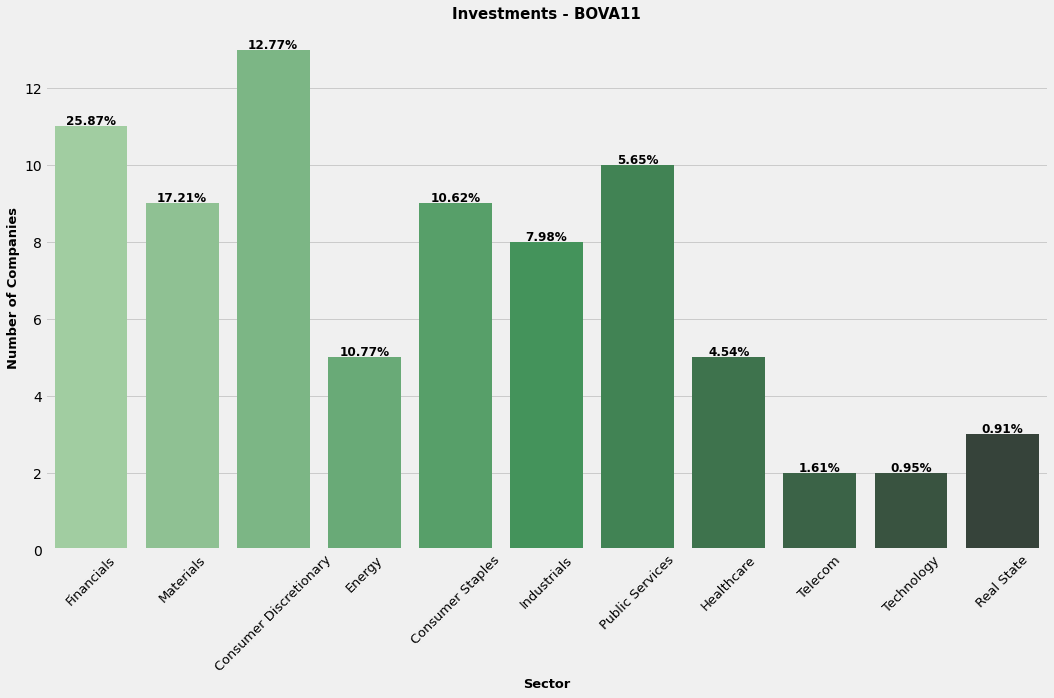

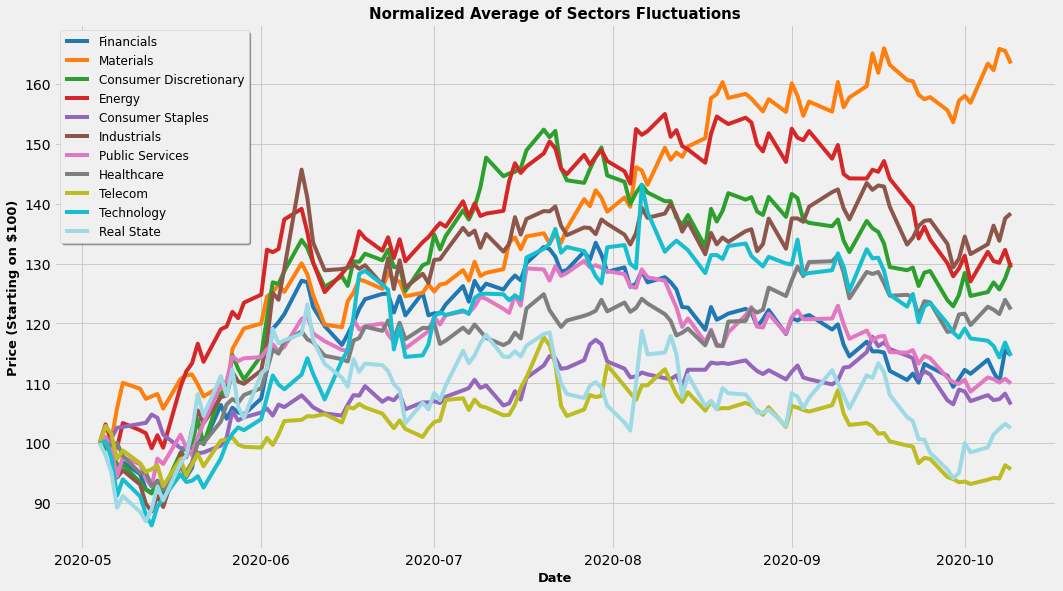

In [8]:
# Merging stock information with its history daily price, calculating daily changes
data = price_hist.merge(bova_stocks.loc[:,['Codigo','Nome','Peso (%)','Setor']], left_on='Stock', right_on='Codigo', how='left').drop('Codigo', axis=1)
data['pct_change_d-1'] = data.groupby('Stock')['close_price'].pct_change(fill_method=None).fillna(0)
data['price_norm'] = 0.0
data = data.sort_values(by=['Stock','Date']).reset_index(drop=True)

actual_stock = ''
for i, row in data.iterrows():
    if row['Stock'] != actual_stock:
        data.at[i, 'price_norm'] = 100
        last_price = 100
        actual_stock = row['Stock']
    else:
        this_value = last_price + last_price * abs(row['pct_change_d-1']) if row['pct_change_d-1'] >= 0 else last_price - last_price * abs(row['pct_change_d-1'])
        data.at[i, 'price_norm'] = this_value
        last_price = this_value

print("Stock level dataset:")
display(data.loc[111:,:].head())

# Grouping by sector
gb_setor = data.groupby(['Date','Setor'], as_index=True).agg(Count = ('Setor','count'), Change = ('pct_change_d-1','mean'), PrecoNormalizado = ('price_norm', 'mean'), Share = ('Peso (%)', 'sum')).rename(columns={'Change' : 'Mean_change_d-1'}).reset_index()
print("Grouped by sector:")
display(gb_setor.head())

# Sector Overview
setor_macroview = gb_setor.loc[:,['Setor','Count','Share']].drop_duplicates().sort_values(by='Share', ascending=False).reset_index(drop=True)
print("Sectors overview:")
display(setor_macroview.head())

# Plotting sectors representations on BOVA11 investments
plt.figure(figsize=(16,9))
splot = sns.barplot(x='Setor', y='Count', data=setor_macroview, palette='Greens_d')
splot.set_xticklabels(splot.get_xticklabels(), rotation=45, fontsize=13)
i = 0
for p in splot.patches:
    splot.annotate(str(format(setor_macroview['Share'][i], '.2f'))+'%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()-0.1), 
                   ha = 'center', va = 'center', fontweight='bold', fontsize=12,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i += 1

splot.set_title('Investments - BOVA11', fontweight='bold', fontsize=15)
splot.set_xlabel('Sector', fontsize=13, fontweight='bold')
splot.set_ylabel('Number of Companies', fontsize=13, fontweight='bold')

# PLotting sectors evolution over time
plt.figure(figsize=(16,9))
setores = setor_macroview['Setor'].unique()
color_qty = len(setores)
cmap = plt.get_cmap('tab20')
cores = [cmap(i) for i in np.linspace(0, 1, color_qty)]
i = 0
for setor in setores:
    plt.plot(pd.to_datetime(gb_setor[gb_setor['Setor'] == setor]['Date']), gb_setor[gb_setor['Setor'] == setor]['PrecoNormalizado'], color=cores[i])
    i += 1

plt.legend(setores, fontsize=12, fancybox=True, frameon=True, shadow=True)
plt.title('Normalized Average of Sectors Fluctuations', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Price (Starting on $100)', fontsize=13, fontweight='bold')
plt.show()
plt.close()


### Sector Details:
- How did the stocks within an equal sector behave ?
- Wich sectors had a similar behaviour between its companies ?

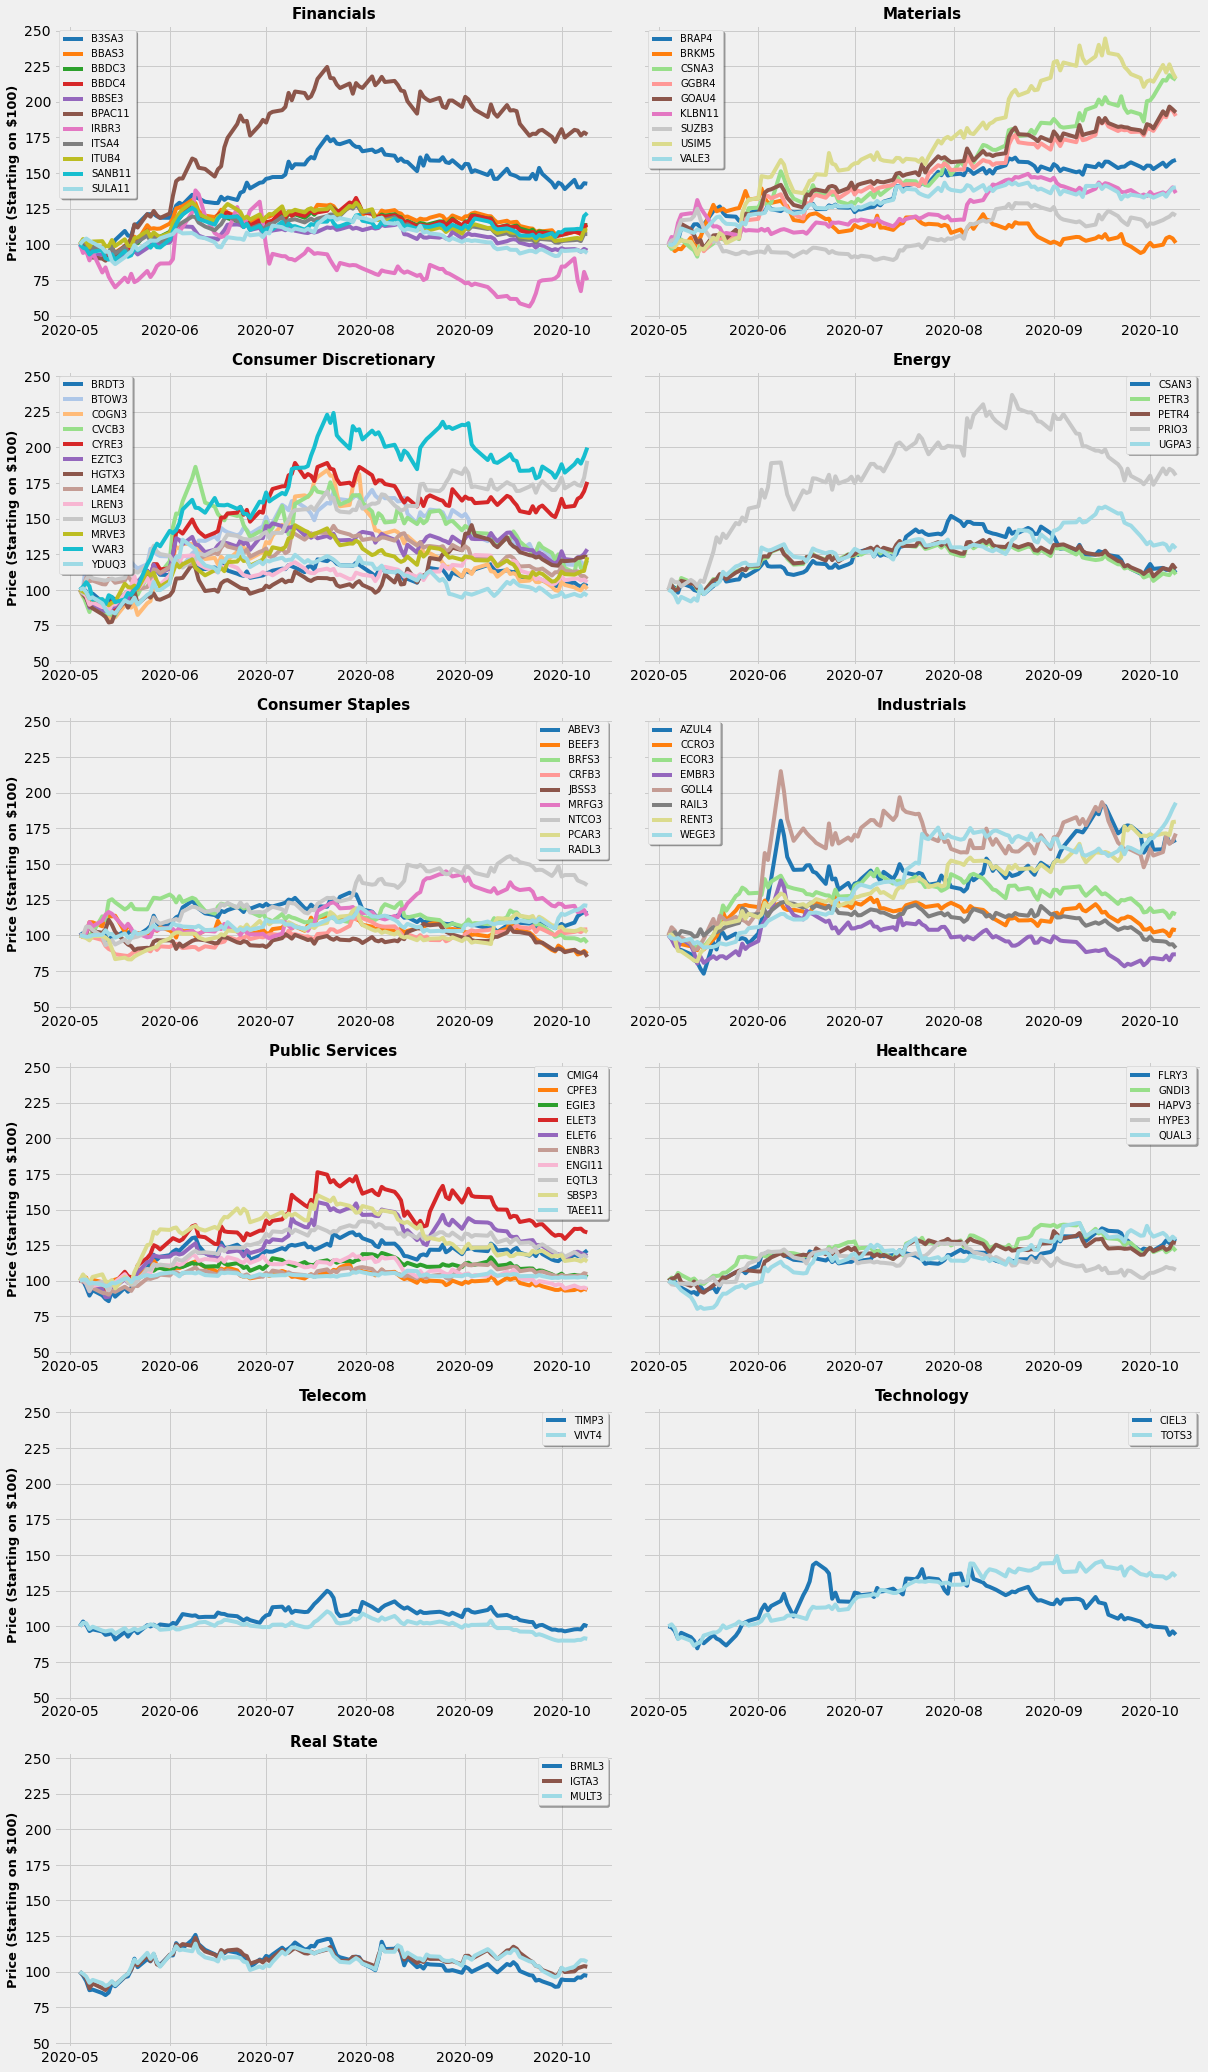

In [9]:
# Detailment per sector
fig, axes = plt.subplots(nrows=len(setores)//2 + 1, ncols=2, figsize=(17,29), sharey=True)
ax_row = 0
ax_col = 0
for setor in setores:
    this_ax = axes[ax_row][ax_col]
    ax_row = ax_row if ax_col == 0 else ax_row + 1
    ax_col = 0 if ax_col == 1 else 1
    stocks_list = data[data['Setor'] == setor]['Stock'].unique()
    color_qty = len(stocks_list)
    cmap = plt.get_cmap('tab20')
    cores = [cmap(i) for i in np.linspace(0, 1, color_qty)]
    i = 0
    for stock in stocks_list:
        stock_data = data[(data['Setor'] == setor) & (data['Stock'] == stock)]
        this_ax.plot(pd.to_datetime(stock_data['Date']), stock_data['price_norm'], color=cores[i])
        i += 1
    this_legend = [stock[:-3] for stock in stocks_list]
    this_ax.legend(this_legend, fontsize=10, fancybox=True, frameon=True, shadow=True)
    this_ax.set_title(setor, fontsize=15, fontweight='bold')
    #this_ax.set_xlabel('Data', fontsize=13, fontweight='bold')
    if ax_col == 1:
        this_ax.set_ylabel('Price (Starting on $100)', fontsize=13, fontweight='bold')
if len(setores)%2 == 1:
    axes.flat[-1].set_visible(False)
plt.tight_layout()
plt.show()
plt.close()

## Trying to fit a model to predict sector next day price change
### Feature Engineering

In [10]:
# Creating bins with daily price changes based on different ranges(positive and negative changes)
classes = ["b_lvl6","b_lvl5","b_lvl4","b_lvl3","b_lvl2","b_lvl1","neutral","g_lvl1","g_lvl2","g_lvl3","g_lvl4","g_lvl5","g_lvl6"]
def var_lvl(row):
    neutral = 0.001
    lvl1 = 0.005
    lvl2 = 0.01
    lvl3 = 0.02
    lvl4 = 0.03
    lvl5 = 0.04
    change = row['pct_change_d-1'] if 'pct_change_d-1' in row else row['Mean_change_d-1']
    if change >= 0:
        if change <= neutral:
            this_class = "neutral"
        elif change <= lvl1:
            this_class = "g_lvl1"
        elif change <= lvl2:
            this_class = "g_lvl2"        
        elif change <= lvl3:
            this_class = "g_lvl3"
        elif change <= lvl4:
            this_class = "g_lvl4"
        elif change <= lvl5:
            this_class = "g_lvl5"
        else:
            this_class = "g_lvl6"
    else:
        change = abs(change)
        if change <= neutral:
            this_class = "neutral"
        elif change <= lvl1:
            this_class = "b_lvl1"
        elif change <= lvl2:
            this_class = "b_lvl2"        
        elif change <= lvl3:
            this_class = "b_lvl3"
        elif change <= lvl4:
            this_class = "b_lvl4"
        elif change <= lvl5:
            this_class = "b_lvl5"
        else:
            this_class = "b_lvl6"
    return this_class

# Creating the column
gb_setor['set_var_lvl'] = gb_setor.apply(var_lvl, axis=1)

#### Simple RandomForestClassifier to predict 'Telecom' performance based on other sectors last 3 days performance

In [11]:
this_setor = 'Telecom'
days = 3
this_df = gb_setor[gb_setor['Setor'] == setor]
this_df = this_df.drop(this_df.columns[1:-1], axis=1).rename(columns={'set_var_lvl': 'output_lvl'}).reset_index(drop=True)
for setor in setores:
    for d in range(1,days+1):
        this_df[setor + ' D-' + str(d)] = ""
    for i,row in this_df.iterrows():
        if i < days:
            continue
        for d in range(1,days+1):
            search_date = this_df.at[i-d,'Date']
            this_df.at[i, setor + ' D-' + str(d)] = gb_setor[(gb_setor['Date'] == search_date) & (gb_setor['Setor'] == setor)]['set_var_lvl'].item()
this_labeled_df = this_df[days:].reset_index(drop=True).drop('Date', axis=1)
display(this_labeled_df.head(3))

,output_lvl,Financials D-1,Financials D-2,Financials D-3,Materials D-1,Materials D-2,Materials D-3,Consumer Discretionary D-1,Consumer Discretionary D-2,Consumer Discretionary D-3,...,Healthcare D-3,Telecom D-1,Telecom D-2,Telecom D-3,Technology D-1,Technology D-2,Technology D-3,Real State D-1,Real State D-2,Real State D-3
0,b_lvl6,b_lvl3,neutral,neutral,g_lvl1,neutral,neutral,g_lvl3,b_lvl2,neutral,...,neutral,b_lvl3,g_lvl4,neutral,b_lvl4,g_lvl1,neutral,b_lvl4,b_lvl4,neutral
1,g_lvl4,b_lvl6,b_lvl3,neutral,g_lvl6,g_lvl1,neutral,b_lvl6,g_lvl3,b_lvl2,...,b_lvl1,b_lvl6,b_lvl3,g_lvl4,b_lvl6,b_lvl4,g_lvl1,b_lvl6,b_lvl4,b_lvl4
2,b_lvl4,g_lvl4,b_lvl6,b_lvl3,g_lvl5,g_lvl6,g_lvl1,g_lvl1,b_lvl6,g_lvl3,...,b_lvl1,g_lvl3,b_lvl6,b_lvl3,g_lvl5,b_lvl6,b_lvl4,g_lvl4,b_lvl6,b_lvl4


Transforming output_lvl to make it a simpler problem (binary classification), making it 1 as a positive price change sign, 0 otherwise

In [12]:
this_labeled_df.output_lvl = this_labeled_df.output_lvl.apply(lambda x: 1 if x.startswith("g") else 0)
this_labeled_df.head(3)

,output_lvl,Financials D-1,Financials D-2,Financials D-3,Materials D-1,Materials D-2,Materials D-3,Consumer Discretionary D-1,Consumer Discretionary D-2,Consumer Discretionary D-3,...,Healthcare D-3,Telecom D-1,Telecom D-2,Telecom D-3,Technology D-1,Technology D-2,Technology D-3,Real State D-1,Real State D-2,Real State D-3
0,0,b_lvl3,neutral,neutral,g_lvl1,neutral,neutral,g_lvl3,b_lvl2,neutral,...,neutral,b_lvl3,g_lvl4,neutral,b_lvl4,g_lvl1,neutral,b_lvl4,b_lvl4,neutral
1,1,b_lvl6,b_lvl3,neutral,g_lvl6,g_lvl1,neutral,b_lvl6,g_lvl3,b_lvl2,...,b_lvl1,b_lvl6,b_lvl3,g_lvl4,b_lvl6,b_lvl4,g_lvl1,b_lvl6,b_lvl4,b_lvl4
2,0,g_lvl4,b_lvl6,b_lvl3,g_lvl5,g_lvl6,g_lvl1,g_lvl1,b_lvl6,g_lvl3,...,b_lvl1,g_lvl3,b_lvl6,b_lvl3,g_lvl5,b_lvl6,b_lvl4,g_lvl4,b_lvl6,b_lvl4


Simple label encode on the categoricals, basic train/val split

In [13]:
sub = len(classes)//2
for idx, classe in enumerate(classes):
    this_labeled_df = this_labeled_df.replace([classe], idx-sub)

display(this_labeled_df.head(3))
# training on 85% of the data, validating on 15% last datapoints
x_train, x_test, y_train, y_test = train_test_split(this_labeled_df.drop('output_lvl', axis=1, inplace=False),this_labeled_df['output_lvl'], shuffle=False, test_size=0.15)

,output_lvl,Financials D-1,Financials D-2,Financials D-3,Materials D-1,Materials D-2,Materials D-3,Consumer Discretionary D-1,Consumer Discretionary D-2,Consumer Discretionary D-3,...,Healthcare D-3,Telecom D-1,Telecom D-2,Telecom D-3,Technology D-1,Technology D-2,Technology D-3,Real State D-1,Real State D-2,Real State D-3
0,0,-3,0,0,1,0,0,3,-2,0,...,0,-3,4,0,-4,1,0,-4,-4,0
1,1,-6,-3,0,6,1,0,-6,3,-2,...,-1,-6,-3,4,-6,-4,1,-6,-4,-4
2,0,4,-6,-3,5,6,1,1,-6,3,...,-1,3,-6,-3,5,-6,-4,4,-6,-4


Building a simple model, predicting and checking its accuracy

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [15]:
# 100 estimators to make sure model isint overfitting too much (500 -> 82% accuracy)
rf = RandomForestClassifier(n_estimators = 100, random_state=0, class_weight="balanced")
rf.fit(x_train.values, y_train.values)
rf_predict = rf.predict(x_test.values)

In [16]:
print(f"Model accuracy on test data: {metrics.accuracy_score(y_test, rf_predict)}")

Model accuracy on test data: 0.7058823529411765


##### Even thought this simple RF is achieving a 70% accuracy score, it is probably overfitting here.
##### More data points and a multi folded cross validation(respecting the timeseries aspect of this dataset) would have been welcome to get more confidence on building a model for this task!
##### I wouldnt recommend that you buy/sell stocks based on the above approach, there are many other dimentions that influence on it and that is probably a task for another project :)